In [324]:
import matplotlib.pyplot as plt
import networkx as nx
import math

In [325]:
# Group class (abstract base class)
class Group:
    def __init__(self, elements):
        self.elements = elements

    def operation(self, a, b):
        raise NotImplementedError('Group operation not implemented')

    def identity(self):
        raise NotImplementedError('Identity element not defined')

    def inverse(self, a):
        raise NotImplementedError('Inverse not implemented')

In [326]:
# Modulo Multiplicative Group class
class ModuloMultiplicativeGroup(Group):
    def __init__(self, n):
        self.n = n
        elements = [x for x in range(1, n) if math.gcd(x, n) == 1]
        super().__init__(elements)
    def operation(self, a, b):
        return (a * b) % self.n
    def identity(self):
        return 1
    def inverse(self, a):
        for x in self.elements:
            if self.operation(a, x) == self.identity():
                return x
        raise ValueError(f'No inverse found for {a} mod {self.n}')

In [327]:
class DirectedGraph:
    def __init__(self):
        self.adj_list = {} # adjacency list
    def __str__(self):
        return '\n'.join([f'{vertex}: {adjacents}' for vertex, adjacents in self.adj_list.items()])
    def add_vertex(self, vertex):
        if vertex not in self.adj_list:
            self.adj_list[vertex] = []
            return f'{vertex} added'
        else:
            return f'{vertex} was previously added'
    def add_edge(self, start, end):
        if start not in self.adj_list:
            self.add_vertex(start)
        if end not in self.adj_list:
            self.add_vertex(end)
        if end in self.adj_list[start]:
            return f'Edge {start} to {end} already exists'
        self.adj_list[start].append(end)
        return f'Edge from {start} to {end} added'
    def nodes(self):
        return list(self.adj_list.keys())
    def edges(self):
        return [(start, end) for start in self.adj_list for end in self.adj_list[start]]
    def bfs(self, start):
        if start not in self.adj_list:
            return f'{start} does not exist'
        visited = set() # store nodes already visited for membership checking purpose
        to_visit = {start: None} # dict is ordered starting 3.7. Here keys are the nodes to visit, values are not used. dict is used because membership checking is O(1)
        route = [] # nodes visited
        while to_visit: # acting like a queue
            visiting = next(iter(to_visit)) #dequeue
            del to_visit[visiting]
            if visiting in visited: # already visited, skipping
                continue
            visited.add(visiting)
            route.append(visiting)
            for v in self.adj_list[visiting]:
                if v not in visited and v not in to_visit:
                    to_visit[v] = None
        return f'BFS visited {route}'
    def dfs(self, start):
        if start not in self.adj_list:
            return f'{start} does not exist'
        visited = set()
        to_visit = [start]
        while to_visit: # acting like a stack
            visiting = to_visit.pop()
            if visiting in visited: # already visited, skipping
                continue
            visited.add(visiting)
            route.append(visiting)
            to_visit.extend([v for v in self.adj_list[visiting] if v not in visited])
        return f'DFS visited {route}'
    def visualize(self, title='Directed Graph'):
        G = nx.DiGraph()
        G.add_edges_from(self.edges())       
        # Handle disconnected subgraphs
        components = list(nx.weakly_connected_components(G))  # For directed graphs
        pos = dict()
        x_offset = 0    
        plt.figure(figsize=(10, 7))
        for component in components:
            subgraph = G.subgraph(component)
            sub_pos = nx.spring_layout(subgraph, seed=42) #, k=1 , scale=1
            
            # Offset subgraph to avoid overlap
            for node in sub_pos:
                sub_pos[node][0] += x_offset
            x_offset += 3  # shift right to avoid overlap (adjust as needed)
            
            pos.update(sub_pos)
        nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray',
                    node_size=200, font_size=10, arrows=True)
        plt.title(title)
        plt.show()

In [328]:
class RSA(): # RSA encryption/decryption/visulization
    def __init__(self, group, e, phi):
        self.group = group
        self.graph = DirectedGraph()
        self.e = e
        self.d = self.compute_d(e, phi)
        self.build_graph()
    @staticmethod
    def text_to_int(text):
        return [ord(c) for c in text]
    @staticmethod
    def int_to_text(integers):
        return ''.join(chr(i) for i in integers)
    @staticmethod
    def _mod_exp_dp(x, exp, n, mem):
        if exp in mem:
            return mem[exp]
        half = RSA._mod_exp_dp(x, exp // 2, n, mem)
        if exp % 2 == 1:
            mem[exp] = (x * half * half) % n
        else:
            mem[exp] = (half * half) % n
        return mem[exp]
    def mod_exp_dp(self, x, exp):
        """
        Calculates x^e mod n using dynamic programming (exponentiation by squaring)
        by storing intermediate results to optimize computation.
        """
        mem = {0: 1, 1: x%self.group.n}
        return RSA._mod_exp_dp(x, exp, self.group.n, mem)
    @staticmethod
    def _EEA(a, b): # Extended Euclidean Algorithm
        if b == 0:
            return a, 1, 0  # gcd, x, y
        else:
            gcd, x1, y1 = RSA._EEA(b, a%b)
            x = y1
            y = x1 - (a // b) * y1
            return gcd, x, y
    def compute_d(self, e, phi):
        gcd, x, _ = RSA._EEA(e, phi)
        if gcd != 1:
            raise Exception("Modular inverse does not exist")
        else:
            return x % phi # in case x<0
    def encrypt(self, msg):
        return [self.mod_exp_dp(x, self.e) for x in RSA.text_to_int(msg)]
    def decrypt(self, ciphertext):
        int_list = [int(s) for s in ciphertext.split(',')]
        return RSA.int_to_text([self.mod_exp_dp(x, self.d) for x in int_list])
    def build_graph(self):
        for x in self.group.elements:
            # Encryption path (e)
            y_encryption = self.mod_exp_dp(x, self.e)
            self.graph.add_edge(x, y_encryption)

            # Decryption path (d)
            y_decryption = self.mod_exp_dp(x, self.d)
            self.graph.add_edge(y_encryption, y_decryption)  # This shows the reverse operation, i.e., decryption
    def visualize(self, title='Visualization of RSA Encryption and Decryption Paths on ℤ*ₙ'):
        group = self.group
        n = group.n
        e = self.e
        d = self.d
        nodes = group.elements
        num_nodes = len(nodes)
        
        # Position nodes on a circle
        positions = {node: (math.cos(2 * math.pi * i / num_nodes), 
                            math.sin(2 * math.pi * i / num_nodes)) 
                     for i, node in enumerate(nodes)}
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_aspect('equal')
    
        # Draw nodes
        for node, (x, y) in positions.items():
            ax.plot(x, y, 'o', markerfacecolor='lightyellow', markeredgecolor='gray', markersize=14)
            ax.text(x, y, str(node), fontsize=9, ha='center', va='center', color='black')    
        # Draw curved edges for encryption and decryption
        for src in nodes:
            enc = self.mod_exp_dp(src, e)
            dec = self.mod_exp_dp(src, d)
            if enc in positions:
                x1, y1 = positions[src]
                x2, y2 = positions[enc]
                # Encryption (blue)
                ax.annotate("",
                            xy=(x2, y2), xycoords='data',
                            xytext=(x1, y1), textcoords='data',
                            arrowprops=dict(arrowstyle="->", color='mediumblue',
                                            connectionstyle="arc3,rad=0.5",
                                            alpha=0.6, mutation_scale=15))
            if dec in positions:
                x1, y1 = positions[src]
                x2, y2 = positions[dec]
                # Decryption (red)
                ax.annotate("",
                            xy=(x2, y2), xycoords='data',
                            xytext=(x1, y1), textcoords='data',
                            arrowprops=dict(arrowstyle="-|>", color='indianred',
                                            connectionstyle="arc3,rad=-0.3",
                                            alpha=0.6, mutation_scale=15))    
        plt.title(title)
        caption = f"RSA encryption (blue) and decryption (red) paths over ℤ*ₙ, showing reversible mappings between public (e={e}) and private (d={d}) exponents."
        # fig.text(0.5, -0.05, caption, ha='center', va='center', fontsize=10, color='black')
        # plt.subplots_adjust(bottom=0.15)
        ax.text(
            0.5, 0, caption,
            ha='center', va='top',
            fontsize=10, color='black',
            transform=ax.transAxes, wrap=True)
        plt.subplots_adjust(bottom=0.25)
        plt.axis('off')
        plt.show()

In [329]:
Max_length = 100
def get_input(prompt):
    user_input = None
    while True:
        try:
            user_input = input(f'Enter {prompt}:')
            assert len(user_input) > 0, f'Cannot exceed {Max_length} characters'
            assert len(user_input) > 0, f'Cannot be empty'
            break
        except AssertionError as msg:
            print(msg)
    return user_input

In [330]:
Bold_start = "\033[1m"
Reset_code = '\033[0m'
def RSA_simulation():
    print(f'{Bold_start}RSA in Action{Reset_code}')
    print('Please enter 2 prime numbers')
    ordinals = {0: ('First', 5), 1: ('Second', 11)}
    primes = list()
    for i in range(2):
        while True:
            try:
                user_input = input(f'{ordinals[i][0]} prime numer (<Enter> = {ordinals[i][1]}): ')
                p = ordinals[i][1] if user_input == '' else int(user_input)
                if not isprime(p): # prime number validation
                    raise ValueError
                primes.append(p)
                break
            except:
                print('Please enter a prime number.')
    n = math.prod(primes)
    group = ModuloMultiplicativeGroup(n)
    phi_n = len(group.elements)
    pub_exps = [x for x in range(3, phi_n) if math.gcd(x, phi_n) == 1]
    e = None
    print(f'An RSA public key consists of two main components:\nthe modulus n = {primes[0]} * {primes[1]} = {n}, and\nthe public exponent e')
    while True:
        try:
            user_input = input(f'Please choose the public exponent from the following list (<Enter> = {pub_exps[0]})\n{pub_exps}')
            e = pub_exps[0] if user_input == '' else int(user_input)
            if e not in pub_exps: # coprime validation
                raise ValueError
            break
        except:
            print(f'Please pick a number from the list {pub_exps}.')
    rsa = RSA(group, e, phi_n)
    print(f'The public key is ({n}, {e}) and private key ({n}, {rsa.d})')
    menu = {'1': ('Encrypt a message', lambda rsa: rsa.encrypt(get_input('a message to encrypt'))),
            '2': ('Decrypt a message', lambda rsa: rsa.decrypt(get_input('the encrypted message (comma-separated integers)'))),
            '3': ('View RSA Exponent Graph', lambda rsa: rsa.visualize()),
            '4': ('Visualize Direc', lambda rsa: rsa.graph.visualize()),
            'q': ('Quit',)
           }
    while True:
        for k, v in menu.items():
            print(f'{k}: {v[0]}')
        choice = input(f'Please select an option: ')
        if choice == 'q':
            break
        if choice in menu:
            result = menu[choice][1](rsa)
            if result is not None:
                print(result)

RSA in Action
Please enter 2 prime numbers


First prime numer (<Enter> = 5):  3
Second prime numer (<Enter> = 11):  11


An RSA public key consists of two main components:
the modulus n = 3 * 11 = 33, and
the public exponent e


Please choose the public exponent from the following list (<Enter> = 3)
[3, 7, 9, 11, 13, 17, 19] 3


The public key is (33, 3) and private key (33, 7)
1: Encrypt a message
2: Decrypt a message
3: View RSA Exponent Graph
4: Visualize Direc
q: Quit


Please select an option:  3


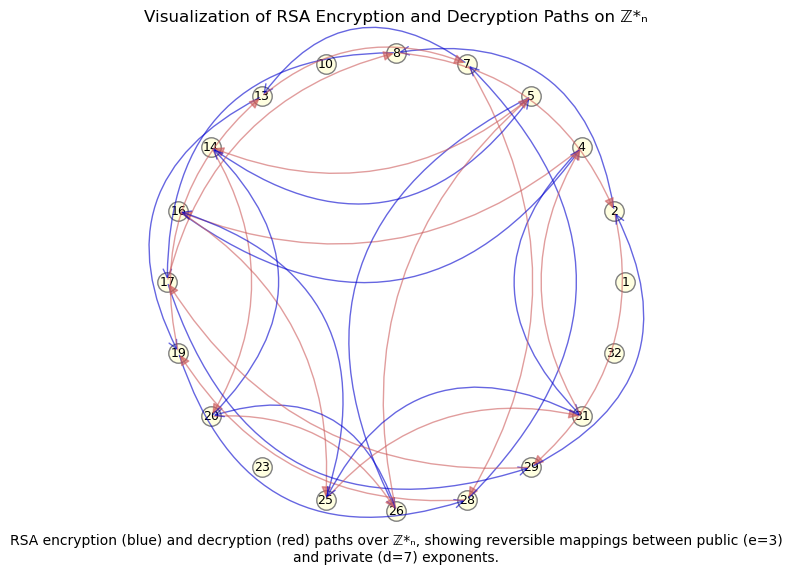

1: Encrypt a message
2: Decrypt a message
3: View RSA Exponent Graph
4: Visualize Direc
q: Quit


In [ ]:
RSA_simulation()